<h1 style="text-align:center">Travail pratique numérique en thermodynamique statistique</h1>
<h2 style="text-align:center">PARTIE 2 : Modèle de Drude</h2>

Veuillez indiquer le nom des membres de votre équipe dans la cellule suivante.

Simon Gauthier, Thomas Charland, Laurent Émond, Anthony Drouin

# Introduction # 
Cette deuxième partie du travail implémente une simulation 2D du modèle de Drude pour décrire le mouvement des électrons libres et indépendants dans les métaux. Des sphères dures sont encore utilisées pour représenter les particules, mais maintenant de deux types différents afin de différencier les coeurs ioniques immobiles des électrons sur leurs trajectoires balistiques. Les collisions entre les deux doivent donc être inélastiques. Les questions sur cette simulation, d'abord de cinétique puis de dynamique des électrons en présence d'une force externe appliquée au cristal, vérifieront quelques résultats analytiques du modèle de Drude obtenus en classe et/ou dans le manuel de cours Ashcroft/Mermin.

- **La remise du présent _Jupyter Notebook_ ET celui de la 1<sup>re</sup> partie, ainsi que tout autre fichier de code produit, se fait sur Gradescope en n'oubliant pas d'y indiquer tous les membres de votre équipe.**

# 2<sup>e</sup> partie - Modèle de Drude #

Faites une copie du script `tds2Danimation_hXX.py` et modifiez-le pour obtenir une simulation cinétique d'un gaz d'électrons libres dans la matière cristalline selon le modèle de Drude. Spécifiquement selon les pp.4-6 du manuel Ashcroft/Mermin,
1. ajoutez un deuxième type de sphères fixes réparties périodiquement dans la boîte d'animation: celles-ci représenteront les coeurs ioniques,
2. éliminez les collisions entre les sphères mobiles qui représentent maintenant les électrons de conduction indépendants et libres,
3. en faisant appel à la température du gaz, ajoutez des collisions inélastiques entre les électrons libres et les coeurs ioniques fixes. La quantité de mouvement $\vec{p}$ n'est alors PAS conservée et il faut appliquer les hypothèses spécifiques du modèle de Drude à la sortie de chaque collision, notamment: 
- la direction de $\vec{p}$ doit être aléatoire,
- la norme $||\vec{p}||$ est déterminée par la distribution de Maxwell-Boltzmann.

### Votre simulation ###

VII. _(25 points)_ &mdash; Écrivez un appel de votre nouveau script pour l'exécuter avec la cellule suivante:

In [2]:
%run Drude_2D_Animation.py
#

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 648.94it/s]


Afin d'obtenir cette simulation, plusieurs modifications ont dues être faites au code initial. 

D'abord, le paramètre initial de masse a du être changé pour la masse de la particule simulée, soit l'électron. 

Ensuite, les coeurs ioniques sont ajoutés lors de l'initialisation de la simulation en un arrangement régulier d'un nombre carré de coeurs (1, 4, 9, 16, etc.). Ces particules ne subissent pas de mouvement, mais créent des collisions avec les électrons en mouvement (qui sont maintenant incapable d'interagir entre eux). D'ailleurs, lors d'une collision, la nouvelle vitesse (et quantité de mouvement) d'un électron est échantillonnée d'une distribution probabilité de Rayleigh $P_p(v)$ de paramètre $s$, soit la version 2D de la loi de Maxwell-Boltzmann 3D ([ref](https://www.sci-pi.org.uk/physics/boltzmann.html)). On a donc:
$$
    P_p(v) = \frac{v}{s^2}e^{-\frac{v^2}{2s^2}}
$$
où $s=\sqrt{\frac{k_BT}{m_e}}$ où $k_B$ est la constante de Boltzmann, $m_e$ la masse de l'électron et $T$ la température moyenne de l'environnement. C'est justement la varition de cette température d'une itération à l'autre qui va faire changer la distribution de quantité de mouvement $p$ dans le temps. En effet, il est impératif que le milieu respecte le principe d'équipartition de l'énergie, soit que:
$$
    \frac{p^2}{2m_e} = \frac{3k_BT}{2}
$$
Il est donc possible d'estimer la température moyenne $T$ à chaque itération avant les collisions, de déterminer la distribution des vitesses et ensuite d'échantillonner sur distribution pour déterminer la vitesse post-collision, qui elle-même influencera la température et la distribution de vitesse à l'itération suivante. 

Ainsi, puisque la distribution de Rayleigh est assymétrique avec une longue queue vers les vitesses élevées, cette boucle d'actualisation de la température et d'échantillonnage sur la distrubution actualisée tendera a réduire l'espérance de la distribution. Cela implique donc que la vitesse moyenne des particles ainsi que leur quantité de mouvement décroitra avec le temps. La question suivante permet de constater cette décroissance.

### Question statistique ###

VIII. _(5 points)_ &mdash; Vérifiez numériquement et graphiquement que l'amortissement de la quantité de mouvement moyenne des électrons suit l'équation exponentielle dérivée analytiquement en classe, soit $\langle p(t)\rangle =\langle p(t_0)\rangle \,e^{-t/\tau}$, et comparez-y le comportement d'un seul électron.

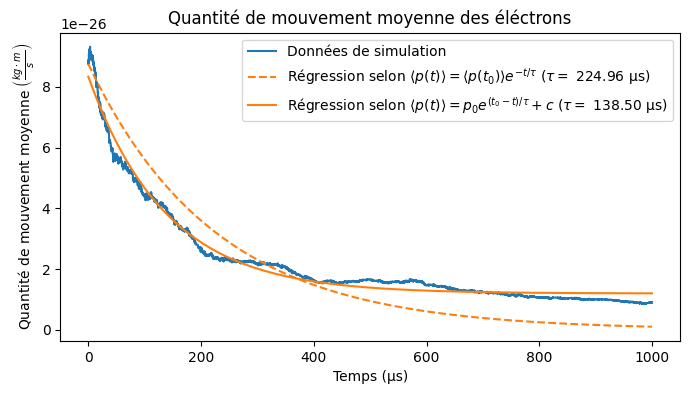

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

momentum_averages = np.array(momentum_averages)
t = np.arange(len(momentum_averages))*dt*1e6
scaled_down_momentum = momentum_averages*1e26 # scale down to avoid leaving the float64 range with np.exp

def complete_expo(t, p0, t0, tau, c):
    return p0*np.exp((t0-t)/tau) + c

def simple_expo(t, tau):
    return scaled_down_momentum[0]*np.exp(-t/tau)

popt, _ = curve_fit(complete_expo, t, scaled_down_momentum, [scaled_down_momentum[0], 0, 200, 0])
(_tau,), _ = curve_fit(simple_expo, t, scaled_down_momentum, [200])

plt.figure(figsize=[8,4])
plt.plot(t, momentum_averages, label="Données de simulation")
plt.plot(t, simple_expo(t, _tau)*1e-26, label=fr"Régression selon $\langle p(t)\rangle =\langle p(t_0)\rangle e^{{-t/\tau}}$ ($\tau =$ {_tau:.2f} µs)", linestyle="--", c="tab:orange")
plt.plot(t, complete_expo(t, *popt)*1e-26, label=fr"Régression selon $\langle p(t)\rangle =p_0e^{{(t_0-t)/\tau}}+c$ ($\tau =$ {popt[-2]:.2f} µs)")
plt.xlabel("Temps (µs)")
plt.ylabel(r"Quantité de mouvement moyenne $\left(\frac{kg\cdot m}{s}\right)$")
plt.title("Quantité de mouvement moyenne des éléctrons")
plt.legend()
plt.show()

On remarque que la régression selon l'équation théorique ne suit pas les données de simulation, alors qu'une régression avec une fonction exponentielle à 4 degrés de liberté est bien meilleure. Cette incohérence avec la théorie peut être attribuée à au faible nombre de particules. On remarque également un régime transitoire formant un pic au début de la simulation qui fausse la régression.

### Dynamique sous l'effet d'une force externe ###

IX. _(10 points)_ &mdash; Pour passer de la cinétique à la dynamique des électrons libres, modifiez votre code de simulation en ajoutant une fonction qui applique un champ électrique uniforme. Celui-ci devra être de module ajustable et perpendiculaire à deux des côtés de la boîte. À chaque pas de temps $\mathrm{d}t$ sans collision, les électrons devront donc accélérer d'un incrément $\mathrm{d}p_x$ dicté par la force de Coulomb à leur position.

Copiez le code de votre fonction dans la cellule qui suit en n'oubliant pas d'inclure votre fichier Python (`.py`) modifié avec la simulation complète lors de la remise.

In [4]:
### Code provenant du fichier Drude_2D_Animation_electric_field.py

#### DANS LA BOUCLE DE SIMULATION, À CHAQUE PAS DE TEMPS DT:

## La condition de conservation de quantité de mouvement est modifiée en début d'itération pour seulement changer le signe si
## et seulement si l'électron est en dehors de la boite ET que sa quantité de mouvement tend à l'éloigner de la boite. Sinon
## il arrivait de changer le signe deux itérations de suite, qui éloignait encore davantage l'électron de la boite en raison 
## de la correction de quantité de mouvement faite par le champ électrique.
def conserver_momentum_at_box_limits(List_Index_Electrons):
    for electron in List_Index_Electrons:
        loc = List_Position_Electrons[electron]
        if loc.x > L/2 and List_Momentum_Electrons[electron].x > 0:
            List_Momentum_Electrons[electron].x *= -1
        if loc.x < -L/2 and List_Momentum_Electrons[electron].x < 0:
            List_Momentum_Electrons[electron].x *= -1

        if loc.y > L/2 and List_Momentum_Electrons[electron].y > 0:
            List_Momentum_Electrons[electron].y *= -1
        if loc.y < -L/2 and List_Momentum_Electrons[electron].y < 0:
            List_Momentum_Electrons[electron].y *= -1

## Pour chaque électron, on vérifie s'il est suffisamment près d'un coeur ionique pour subir une collision. Cette fonction
## diffère seulement de celle implantée dans la partie 1 du devoir par l'ajout d'une liste d'électrons n'ayany pas subit de
## collisions puisque ce sont ces électrons qui devront subir un incrément de quantité de mouvement du au champ électrique.
def checkCollisions() -> list[tuple[int, int]]:
    electrons_with_hits = [] # electrons that collide with ions
    ions_with_hits = [] # corresponding ion from collisions in electrons_with_hits
    r2 = Relectron + Rion   # distance critique où les 2 sphères entre en contact à la limite de leur rayon
    r2 *= r2   # produit scalaire pour éviter une comparaison vectorielle ci-dessous
    for i in range(Nelectrons):
        ai = List_Position_Electrons[i]
        for j in range(Nions):  # On compare chaque atome avec chaque coeur ionique
            aj = List_Position_Electrons[j + Nelectrons]
            dr = ai - aj
            if mag2(dr) < r2:
                electrons_with_hits.append(i) # add the index of the electron
                ions_with_hits.append(j + Nelectrons) # add the index of the ion

    hitlist = zip(electrons_with_hits, ions_with_hits) # combine the two lists to have a list of collisions as tuples
    no_hitlist = list(set(range(Nelectrons)) - set(electrons_with_hits)) # find the electron indices that did not have any collision
 
    return hitlist, no_hitlist

## Ensuite une itération est faite sur les électrons qui n'ont pas subit de collisions. Un incrément de quantité de mouvement
## en x est calculé à partir de l'effet de la force de Coulomb. Si l'électron est déjà en dehors du cadre suite à l'itération
## précédente ET que l'incrément l'en éloigne encore plus, cela signifie que le champ électrique en x est plus fort que la
## quantité de mouvement actuelle en x. Dans ce cas, l'électron doit cesser de bouger en x et se coller au cadre sous l'effet
## du champ électrique. Sinon, dans le cas normal, l'incrément est simplement ajouté à la composante en x de la quantité de
## mouvement et la nouvelle position est calculée.
def update_no_hit_electrons(no_hitlist):
    for no_hit in no_hitlist:  
        momentum_electron = List_Momentum_Electrons[no_hit] # get the momentum of the electron
        momentum_electron_x = momentum_electron.x # get the x component of the momentum
        momentum_electron_y = momentum_electron.y
        momentum_electron_z = momentum_electron.z
    
        momentum_increment = dt*(-momentum_electron_x/_tau + q*electric_field) # apply Coulomb's force as in A/M 1.12
    
        position = List_Position_Electrons[no_hit]

        
        if position.x > L/2:
            if momentum_increment > 0: # arrête l'électron si le champ électrique est plus fort que le momentum précédent
                momentum_electron_x = 0
                List_Position_Electrons[no_hit].x = L/2
        elif position.x < -L/2:
            if momentum_increment < 0: # arrête l'électron si le champ électrique est plus fort que le momentum précédent
                momentum_electron_x = 0
                List_Position_Electrons[no_hit].x = -L/2
        else:
            momentum_electron_x += momentum_increment # ajoute l'incrément de momentum causé par le champ électrique en x
    
            List_Momentum_Electrons[no_hit] = vector(momentum_electron_x, momentum_electron_y, momentum_electron_z)
    
            new_position = position + List_Momentum_Electrons[no_hit]/mass * dt # calcule la nouvelle position
    
            List_Position_Electrons[no_hit] = new_position

### Question statistique ###

X. _(5 points)_ &mdash; Pour quelques différents modules de champ électrique, présentez graphiquement l'évolution de la position moyenne des électrons en fonction du temps pour ses deux composantes parallèle et perpendiculaire au champ.

Pour cette question, le script Drude_2D_Animation_electric_field.py est appellé avec des arguments `--efield`, `--tau` et `noshow`, qui permettent, respectivement, de définir la norme du champ magnétique appliqué en `x` vers la droite (pour `efield > 0`), de déterminer la constante de temps (trouvée sur le graphique ci-dessus) et d'éviter que la fenêtre de visualisation d'apparaisse lors de la simulation. La figure ci-dessous présente la position moyenne parallèle ($s_{\parallel}$) et perpendiculaire ($s_{\perp}$) au champp électrique appliqué. 

In [5]:
__tau = _tau *1e-6 # convert from µs to s. `tau` is not used since it is already used by vpython as 2pi 

efields = [0.01, 0.025, 0.05, 0.1]

for i, efield in enumerate(efields):
    %run Drude_2D_Animation_electric_field.py --efield $efield --tau $__tau --noshow
    if i == 0:
        n = len(position_x_averages)
        t = np.arange(n)*dt*1e6 # x_axis in µs
        x_positions = np.zeros((len(efields), n))
        y_positions = np.zeros((len(efields), n))
    x_positions[i, :] = position_x_averages
    y_positions[i, :] = position_y_averages

100%|████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 511.31it/s]


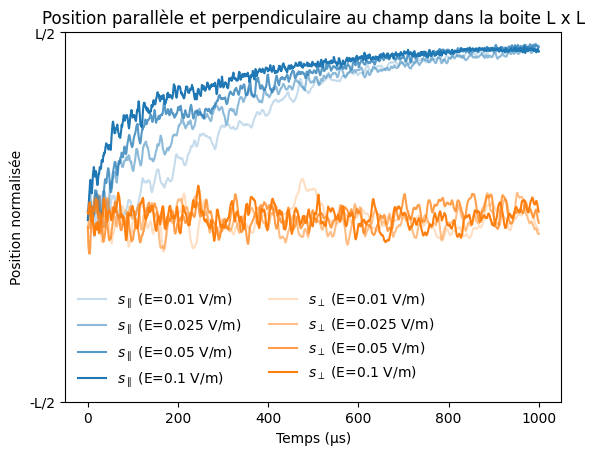

In [8]:
for i, efield in enumerate(efields):
    plt.plot(t, x_positions[i], c="tab:blue", label=fr"$s_\parallel$ (E={efield} V/m)", alpha=0.25*(i+1))
for i, efield in enumerate(efields): 
    plt.plot(t, y_positions[i], c="tab:orange", label=fr"$s_\perp$ (E={efield} V/m)", alpha=0.25*(i+1))

plt.title("Position parallèle et perpendiculaire au champ dans la boite L x L")
plt.legend()
plt.ylim([-0.5, 0.5])
plt.yticks([-0.5, 0.5], labels=["-L/2", "L/2"])
plt.ylabel("Position normalisée")
plt.xlabel("Temps (µs)")
plt.legend(ncol=2, loc="best", frameon=False)
plt.show()

On remarque exactement l'effet attendu, où la position parallèle au champ tend vers le bord de la boite ($L/2$) alors que la position perpendiculaire au champ oscille au centre de la boite, indifférente au champ électrique. On remarque aussi que l'augmentation de la force de champ électrique fait tendre plus rapidement la position moyenne parallèle au champ vers $L/2$, ce qui est logique. Cette simulation est faite avec 500 électrons et 10k itérations, il est certain que d'augmenter le nombre d'électrons viendrait lisser les courbes, mais le comportement est tout de même assez facile à voir ainsi. Le nombre d'itérations est aussi suffisant pour atteindre le régime permanent.

# Médiagraphie #
- P. Drude, _Zur Elektronentheorie der Metalle; I Teil_, Annalen der Physik **306**(3), pp.566–613 (1900) https://doi.org/10.1002/andp.19003060312
- P. Drude, _Zur Elektronentheorie der Metalle; II Teil. Galvanomagnetische und Thermomagnetische Effecte_, Annalen der Physik **308**(11), pp.369–402 (1900) https://doi.org/10.1002/andp.19003081102
- P. Drude, _Zur Elektronentheorie der Metalle; Berichtigung_, Annalen der Physik **312**(3), pp.687–692 (1902) https://doi.org/10.1002/andp.19023120312
- H. A. Lorentz, _The Motion of Electrons in Metallic Bodies I_, Proc. of Koninklijke Akademie van Wetenschappen **7**, pp.438-453 (1905) https://dwc.knaw.nl/DL/publications/PU00013989.pdf
- H. A. Lorentz, _The Motion of Electrons in Metallic Bodies II_, Proc. of Koninklijke Akademie van Wetenschappen **7**, pp.585-593 (1905) https://dwc.knaw.nl/DL/publications/PU00014010.pdf
- H. A. Lorentz, _The Motion of Electrons in Metallic Bodies III_, Proc. of Koninklijke Akademie van Wetenschappen **7**, pp.684-691 (1905) https://dwc.knaw.nl/DL/publications/PU00014024.pdf
 - La simulation utilise la librairie <a href="https://vpython.org">VPython</a> conçue pour la visualisation de physique en 3D, avec les instructions d’installation <a href="https://vpython.org/presentation2018/install.html">ici</a> et la documentation <a href="https://www.glowscript.org/docs/VPythonDocs/index.html">ici</a>. Le script fourni qui est exécuté dans ce _Notebook_ adapte en 2D et commente en détail l’exemple <a href="https://www.glowscript.org/#/user/GlowScriptDemos/folder/Examples/program/HardSphereGas-VPython">HardSphereGas-VPython</a> du site interactif <a href="https://www.glowscript.org">GlowScript</a> pour programmer des animations avec VPython directement en ligne.
 
_**N.B. de débogage VPython:** Ayant plus codé en MATLAB qu'en Python jusqu'à maintenant, j'utilise Spyder qui offre une interface similaire, mais j'ai trouvé ce vidéo qui parle d'une <a href="https://www.youtube.com/watch?v=MJiVtz4Uj7M">installation VS code</a> qui peut-être aider? N'hésitez pas à partager de meilleures alternatives que j'ajouterai ici. Vous pouvez aussi tenter l'installation <a href="https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/">directement dans le Notebook</a>, mais au final chaque installation de distribution Python a son lot de <a href="https://xkcd.com/2347/">défis avec les dépendances</a>. Si rien ne fonctionne, n'hésitez pas à contacter la sympathique communauté qui développe et utilise cette librairie VPython d'abord via leur <a href="https://groups.google.com/g/vpython-users">groupe-forum</a>, puis leur <a href="https://github.com/vpython/vpython-jupyter">site GitHub</a> de dépôt de développement. J'ai toujours eu de bonnes expériences d'interaction avec eux!_ 
 